### Loading up our saved models

In [33]:
using ONNXNaiveNASflux
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances, MLDatasets, CSV, DataFrames
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!

In [2]:
adv_pgd_strong = ONNXNaiveNASflux.load("../models/adv_pgd_strong.onnx")
adv_pgd_medium = ONNXNaiveNASflux.load("../models/adv_pgd_medium.onnx")
adv_pgd_weak = ONNXNaiveNASflux.load("../models/adv_pgd_weak.onnx")
model = ONNXNaiveNASflux.load("../models/classically_trained.onnx")

CompGraph with graphsummary:
┌────────────────┬───────────┬────────────────┬─────────────────────────┐
│ Graph Position │ Vertex Nr │ Input Vertices │ Op                      │
├────────────────┼───────────┼────────────────┼─────────────────────────┤
│ Input          │ 1         │                │                         │
│ Hidden         │ 2         │ 1              │ Dense(784 => 128, relu) │
│ Output         │ 3         │ 2              │ Dense(128 => 10)        │
└────────────────┴───────────┴────────────────┴─────────────────────────┘


In [41]:
adv_pgd_medstr = ONNXNaiveNASflux.load("../models/adv_pgd_medstr.onnx")
adv_pgd_med2 = ONNXNaiveNASflux.load("../models/adv_pgd_medstr.onnx")

CompGraph with graphsummary:
┌────────────────┬───────────┬────────────────┬─────────────────────────┐
│ Graph Position │ Vertex Nr │ Input Vertices │ Op                      │
├────────────────┼───────────┼────────────────┼─────────────────────────┤
│ Input          │ 1         │                │                         │
│ Hidden         │ 2         │ 1              │ Dense(784 => 128, relu) │
│ Output         │ 3         │ 2              │ Dense(128 => 10)        │
└────────────────┴───────────┴────────────────┴─────────────────────────┘


### Loading up our MNIST data

In [32]:
train_df = CSV.read("../data/mnist_train.csv", DataFrame; header=false)
train_data = Matrix(train_df)

test_df = CSV.read("../data/mnist_test.csv", DataFrame; header=false)
test_data = Matrix(test_df)

x_train = train_data[:, 2:785]' ./ 255
y_train = train_data[:, 1]

x_test = test_data[:, 2:785]' ./ 255
y_test = test_data[:, 1]

x_train

784×60000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Preparing models for Counterfactual generation

In [42]:
using CounterfactualExplanations

flux_clean = CounterfactualExplanations.MLP(model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi)
flux_adv_medstr = CounterfactualExplanations.MLP(adv_pgd_medstr; likelihood=:classification_multi)
flux_adv_med2 = CounterfactualExplanations.MLP(adv_pgd_med2; likelihood=:classification_multi)

CounterfactualExplanations.Models.Model(CompGraph(3 vertices), :classification_multi, CounterfactualExplanations.Models.Fitresult(CompGraph(3 vertices), Dict{Any, Any}()), MLP())

### Plot random counterfactuals

In [5]:
counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.1])
convergence = CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.7, max_iter=1000)

CounterfactualExplanations.Convergence.GeneratorConditionsConvergence(0.7, 0.01, 1000, 0.75)

CounterfactualExplanation
Convergence: ❌ after 1000 steps.
image = [0.0, 4.1791768799370745e-6, 0.0, 9.113099119772983e-6, 0.0, 0.0, 5.415345970671837e-6, 5.58029875916688e-6, 1.1853856818433428e-5, 3.011585485523938e-6, 0.0, 1.37436050241746e-5, 0.0, 5.792820971262103e-6, 9.46021372651984e-6, 8.41482145101935e-6, 9.14579892299372e-6, 1.1804585693386827e-5, 7.415320626158462e-6, 4.0694096636428865e-6, 0.0, 0.0, 7.211876858548295e-6, 5.759454918763396e-6, 7.649643171880883e-6, 5.834413692440421e-6, 0.0, 4.8785614692903325e-6, 6.556836086613061e-6, 0.0, 1.259954452947909e-5, 0.0, 6.18912457159837e-6, 0.0, 7.097680887291347e-6, 0.0, 8.363229339192202e-6, 5.747375791731457e-6, 9.565300774827535e-6, 2.0377788826131392e-6, 0.0, 8.75960425696931e-6, 1.3397699958517251e-5, 5.8718944734081905e-6, 8.204537743328188e-6, 0.0, 5.742910469574981e-6, 9.86433021008537e-6, 9.268664011319318e-6, 6.036848346813173e-6, 1.1026214669662694e-5, 0.0, 4.8407267800421046e-6, 7.5411310397122126e-6, 1.59491194771

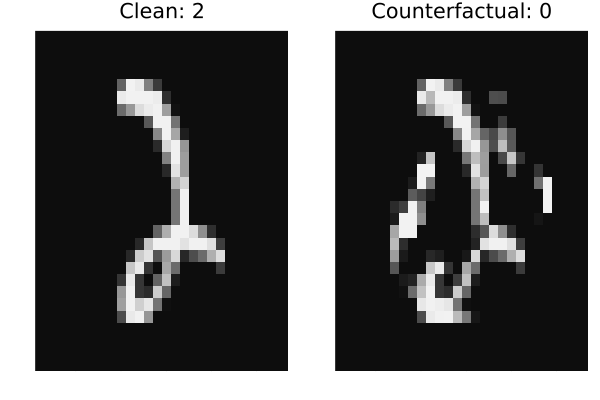

In [38]:
include("../utils/plot.jl")

using CounterfactualExplanations.Evaluation: evaluate, validity

# model_to_use = flux_clean
# model_to_use = flux_adv_strong
model_to_use = flux_adv_medstr
# model_to_use = flux_adv_medium
# model_to_use = flux_adv_weak

# random point's Counterfactual
index = rand(1:10000)

different_label = rand(0:8)
if different_label >= y_test[index]
    different_label += 1
end
 
ce = generate_counterfactual(
        reshape(x_test[:, index], 784, 1), different_label, counterfactual_data, model_to_use, generator; num_counterfactuals=1, convergence=convergence
    )

println(ce)

ces = CounterfactualExplanations.counterfactual(ce)
cfimage = ces[:, 1]
println("image = ", cfimage)
println("correct_class = ", ce.target)
println("also should be same: ", different_label)

# inf_model = model
# inf_model = adv_pgd_strong
inf_model = adv_pgd_medstr
# inf_model = adv_pgd_medium
# inf_model = adv_pgd_weak

cf_pred = (inf_model(cfimage) |> Flux.onecold |> getindex) - 1
println("valid? ", evaluate(ce; measure=validity)[1][1])
actualimage = x_test[:, index]
actual_pred = (inf_model(actualimage) |> Flux.onecold |> getindex) - 1
plot_normal_and_ce(actualimage, actual_pred, cfimage, cf_pred, y_test[index])

### Experimental Setup

In [15]:
Random.seed!(42)

function generate_split(num_datapoints)
    rand(1:num_datapoints, 200)
end

function random_excluding(exclude)
    value = rand(0:8)
    return value < exclude ? value : value + 1
end

split = generate_split(length(y_test))
targets = [random_excluding(y_test[num]) for num in split]

split
targets
# splits = [generate_split(length(y_test)) for _ in 1:5]
# targets = [[random_excluding(y_test[num]) for num in split] for split in splits]

200-element Vector{Int64}:
 7
 8
 7
 8
 5
 7
 7
 8
 0
 3
 ⋮
 9
 9
 6
 4
 6
 0
 9
 1
 2

#### Experiment: Clean Model

In [ ]:
using CounterfactualExplanations

model_to_use = model
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_clean, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(784 => 128, relu)
│   summary(x) = 784-element Vector{Float64}
└ @ Flux /root/.julia/packages/Flux/97jpP/src/layers/stateless.jl:59


counterfactual instance: [0.0, 0.0, 0.0, 5.7624500004749284e-5, 0.00012153342504461762, 0.0, 0.0, 0.0, 2.8151048354629893e-5, 0.0, 1.2070123784724275e-5, 0.0, 0.0, 0.0, 0.0, 0.00013697097019758076, 0.0, 0.0, 0.0, 0.0, 7.560561316495297e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.461301886200091e-5, 4.0047571565082764e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.067849333499908e-5, 0.0, 0.0, 0.0002802821582008619, 0.0, 2.4606785154901447e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003688425491418457, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025511331186862664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00014938519764109515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.781561435971526e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06291284740376808, 0.4264516683742396, 0.4314672899407433, 0.30483338172

196-element Vector{Any}:
 [0.0, 0.0, 0.0, 5.7624500004749284e-5, 0.00012153342504461762, 0.0, 0.0, 0.0, 2.8151048354629893e-5, 0.0  …  0.00011378985545889009, 0.000537484438973479, 0.7421172705597336, 0.9432954472546259, 0.538145509762815, 0.0, 0.0, 7.005674187894328e-5, 1.1909031991308439e-5, 7.0]
 [0.00011472191365555773, 9.199987766805862e-6, 0.0, 0.0, 7.440498416144692e-5, 1.1309604872167256e-5, 0.0, 0.0, 0.0, 0.0  …  0.00021384738170127093, 0.0, 0.0, 3.924415450455854e-5, 0.0, 0.0, 0.0, 1.0300297481080635e-5, 4.822963023798366e-6, 8.0]
 [0.0, 2.352156532197114e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010071669803437545, 0.0  …  0.0, 0.0005844307081133593, 0.1733732782820025, 0.08782367113508951, 0.00015221886189829094, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 6.409057044720612e-5, 3.2488325359736336e-5, 0.0, 9.036216238200724e-6, 0.0, 5.961647000276571e-5, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.372101208100504e-5, 8.0]
 [0.0, 0.0, 0.0, 4.6103926115392825e-5, 0.0, 0.0, 0.0

In [12]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,5.76245e-5,0.000121533,0.0,0.0,0.0,2.8151e-5,0.0,1.20701e-5,0.0,0.0,0.0,0.0,0.000136971,0.0,0.0,0.0,0.0,7.56056e-5,0.0,0.0,0.0,0.0,0.0,8.4613e-5,4.00476e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.06785e-5,0.0,0.0,0.000280282,0.0,2.46068e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000368843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000255113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.000114722,9.19999e-6,0.0,0.0,7.4405e-5,1.13096e-5,0.0,0.0,0.0,0.0,0.000118431,0.0,1.6989e-5,0.0,0.0,0.0,0.0,7.4934e-6,0.0,0.0,0.0,1.5803e-5,0.0,0.0,0.0,0.0,0.0,1.04363e-5,8.42664e-5,8.46346e-5,0.0,7.20749e-5,0.0,0.0,0.000117956,5.84124e-5,0.0,0.0,0.000238788,0.0,0.000139709,0.000292323,0.000477097,0.000548319,0.0,0.0,0.000287915,0.000349924,0.000588486,0.0,0.0,0.0,0.0,0.0,0.0,4.30353e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.000150929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000384311,0.246185,0.537198,0.0,0.0,0.0,0.000276198,5.95507e-6,0.0,0.0,0.0,3.17135e-5,0.0,0.000104632,0.0,0.0,0.0,0.0,0.0,0.0,0.000532374,0.0,0.0281397,0.0,0.0,0.0,0.0,0.000107966,⋯
3,0.0,2.35216e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.000100717,0.0,0.0,0.0,0.0,0.0,0.0,0.000189165,0.0,0.0,4.45582e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6734e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.96696e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.74899e-6,0.0,0.0,0.0,0.0,0.0,2.0868e-5,0.000216171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.45534e-5,0.0,0.0,0.0001188,2.9234e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,6.40906e-5,3.24883e-5,0.0,9.03622e-6,0.0,5.96165e-5,0.0,0.0,0.0,2.27439e-5,2.25948e-5,0.0,3.0996e-5,0.0,0.000150016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9949e-6,0.0,4.92203e-5,8.19922e-5,0.0,1.34251e-5,0.00012056,7.28351e-5,1.11817e-5,4.23864e-5,0.0,0.0,0.0,0.0,0.00015466,2.4365e-5,1.74218e-5,0.000272116,0.000272659,0.0,0.0,0.000187824,7.73275e-5,0.0,4.0414e-5,0.0,0.0,0.0,0.0,5.87446e-5,0.000105381,0.0,0.000157733,0.000194582,0.000114615,0.000287517,0.0,0.000277778,0.000701798,0.0,0.0,0.0,0.0,0.0,7.34211e-5,0.0,0.0,0.0,0.000243761,0.0,8.01098e-5,0.0,8.16568e-5,0.0,0.0,0.00010755,0.0,0.0,0.0,0.00880337,0.000205635,0.166579,0.000500669,0.328868,0.0,0.0,0.0,0.0,0.0,0.0,9.31261e-5,⋯
5,0.0,0.0,0.0,4.61039e-5,0.0,0.0,0.0,0.0,0.0,6.80545e-5,0.0,0.0,0.0,0.0,0.0,0.0,4.93159e-6,0.0,0.0,0.0,7.3439e-5,0.0,0.0,2.46301e-6,0.000112877,0.0,3.20677e-5,0.0,0.0,0.0,6.7383e-5,0.0,0.0,5.91716e-5,0.0,0.0,0.0,6.5423e-5,0.000103766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000124236,0.0,3.17822e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.54487e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000119846,0.000247097,0.0,0.0,0.0,0.0,2.53088e-5,2.

#### Experiment: Strong AT model

In [25]:
using CounterfactualExplanations

model_to_use = adv_pgd_strong
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_adv_strong, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

counterfactual instance: [1.0342726426415539e-7, 0.0, 3.961481964154246e-6, 0.0, 0.0, 0.0, 8.901688681817177e-6, 1.3685320885770126e-5, 0.0, 9.384729000316839e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.955068694982856e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.340245691878409e-5, 6.641474087132338e-7, 0.0, 0.0, 1.0855253326269577e-5, 0.0, 0.0, 0.0, 0.0, 2.3945616976561724e-5, 1.1813971539709202e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.218956644625905e-7, 0.0, 3.4718049093385165e-7, 3.4256597174930905e-6, 0.0, 0.0, 0.0, 1.009706825811918e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.133513912383478e-6, 0.0, 0.0, 9.691555402469022e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0169108949042994e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3903055202367798e-5, 0.0, 0.0, 0.0001396792656285016, 0.0, 0.0, 0.0, 2.7022985605640315e-5, 0.0, 4.0765077898186066e-6, 0.0, 0.0, 0.0, 0.0, 0.0

195-element Vector{Any}:
 [1.0342726426415539e-7, 0.0, 3.961481964154246e-6, 0.0, 0.0, 0.0, 8.901688681817177e-6, 1.3685320885770126e-5, 0.0, 9.384729000316839e-6  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [0.00019770445532572012, 0.00010854352007640956

In [21]:
counterfactuals[1][1:784]
split[1]

6294

In [26]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data_strong_at.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1.03427e-7,0.0,3.96148e-6,0.0,0.0,0.0,8.90169e-6,1.36853e-5,0.0,9.38473e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.95507e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34025e-5,6.64147e-7,0.0,0.0,1.08553e-5,0.0,0.0,0.0,0.0,2.39456e-5,1.1814e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.21896e-7,0.0,3.4718e-7,3.42566e-6,0.0,0.0,0.0,1.00971e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.13351e-6,0.0,0.0,9.69156e-6,0.0,0.0,0.0,0.0,0.0,1.01691e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000101133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.35497e-5,0.0,0.0,0.000178686,0.0,0.0,0.0,0.0,0.0,0.0,3.30813e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2784e-6,0.0,0.0,7.62343e-5,2.38937e-5,3.62325e-5,0.0,0.000141729,0.0,0.0,0.0,⋯
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [27]:
using CounterfactualExplanations

model_to_use = adv_pgd_weak
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_adv_weak, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

counterfactual instance: [0.0, 0.0, 0.0, 3.82135113682125e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1809264680096022e-5, 0.0, 6.223409243943934e-6, 0.0, 1.831017891618103e-5, 1.4306424628784954e-5, 0.0, 2.7787847523086386e-5, 1.5364451365940115e-5, 0.0, 0.0, 1.4267590557892618e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 1.58744669022326e-5, 0.0, 1.4018860795772525e-5, 0.0, 1.0992878353022207e-5, 0.0, 0.0, 0.0, 4.107182751340588e-5, 0.0, 2.3705023704678754e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5984366120846973e-5, 1.6439345802155004e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.341666846883527e-5, 0.0, 0.0, 1.827267821568057e-5, 0.0, 0.0, 0.0, 1.3559676483509975e-5, 2.1064795589609275e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9043243139549307e-5, 0.0, 0.0, 0.0, 9.899886211428566e-6, 0.0, 1.4248349953049911e-5, 3.29675844227495e-5, 0.0, 4.145675853806097e-6, 0.0, 0.0, 0.0, 1.670125611781259e-5, 0.0, 3.086646991334874e-5, 3.513088851718749e-5, 0.0, 0.0, 0.0, 0.00018014782617683525, 0.0001437406455

199-element Vector{Any}:
 [0.0, 0.0, 0.0, 3.82135113682125e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1809264680096022e-5  …  0.0, 1.7791267043776316e-5, 0.0, 0.0, 0.0, 4.332436795806416e-6, 2.807815221785859e-5, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [8.827220938201208e-6, 4.894790032494712e-6, 1.2909395070437314e-5, 0.0, 0.0, 0.0, 0.0, 2.1834671969145346e-6, 0.0, 6.9810443051210315e-6  …  0.0, 0.0, 0.0, 4.143332299122449e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 3.620547587956935e-6, 0.0, 0.0, 4.230376158886884e-6, 0.0, 0.0, 0.0, 0.0, 8.0]
 [4.039448078856367e-5, 2.5906334059300207e-5, 0.0, 3.8517261691595196e-5, 4.97973462643131e-7, 4.894916618241041e-5, 0.0, 0.0, 2.144965866364146e-5, 2.7686375960911392e-5  …  0.0, 1.1846146060179308e-5, 3.1268245942328575e-5, 0.0, 0.0, 0.0, 2.290690940753848e-6, 3.648776225873007e-5, 2.581104009777846e-5, 5.0]
 [0.0, 0.0, 0.0, 

In [28]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data_weak_at.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,3.82135e-5,0.0,0.0,0.0,0.0,0.0,1.18093e-5,0.0,6.22341e-6,0.0,1.83102e-5,1.43064e-5,0.0,2.77878e-5,1.53645e-5,0.0,0.0,1.42676e-6,0.0,0.0,0.0,0.0,0.0,1.58745e-5,0.0,1.40189e-5,0.0,1.09929e-5,0.0,0.0,0.0,4.10718e-5,0.0,2.3705e-5,0.0,0.0,0.0,0.0,0.0,0.0,1.59844e-5,1.64393e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.34167e-5,0.0,0.0,1.82727e-5,0.0,0.0,0.0,1.35597e-5,2.10648e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.90432e-5,0.0,0.0,0.0,9.89989e-6,0.0,1.42483e-5,3.29676e-5,0.0,4.14568e-6,0.0,0.0,0.0,1.67013e-5,0.0,3.08665e-5,3.51309e-5,0.0,0.0,0.0,0.000180148,0.000143741,0.0,0.0,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.76612e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.54572e-5,⋯
3,8.82722e-6,4.89479e-6,1.29094e-5,0.0,0.0,0.0,0.0,2.18347e-6,0.0,6.98104e-6,2.69626e-7,1.00026e-5,0.0,0.0,0.0,0.0,5.11043e-6,4.84968e-7,0.0,0.0,7.76645e-6,0.0,2.08911e-5,0.0,0.0,0.0,0.0,0.0,0.0,3.20112e-6,0.0,5.8475e-6,8.74389e-6,0.0,0.0,0.0,0.0,0.0,0.0,7.86499e-6,2.61377e-6,0.0,0.0,0.0,1.62641e-5,0.0,0.0,0.0,0.0,0.0,0.0,1.8819e-6,0.0,0.0,1.30876e-5,0.0,0.0,0.0,0.0,8.83491e-6,0.0,4.21744e-6,0.0,0.0,0.0,2.38605e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.49655e-6,0.0,0.0,0.0,0.0,1.13334e-5,1.49077e-6,0.0,0.0,5.54478e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.51302e-5,7.43255e-5,0.0,1.44529e-5,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.43961e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.54248e-5,1.79233e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.66727e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.18085e-6,4.25582e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.91457e-6,0.0,0.0,0.0,8.01963e-5,0.0,0.0,2.60712e-5,0.0,0.0,⋯
5,4.03945e-5,2.59063e-5,0.0,3.85173e-5,4.97973e-7,4.89492e-5,0.0,0.0,2.14497e-5,2.76864e-5,3.03898e-5,1.8047e-5,4.30546e-5,0.0,2.13541e-5,9.61866e-6,2.88038e-5,0.0,4.02394e-5,0.0,2.13822e-5,2.78148e-6,0.0,2.35822e-5,0.0,0.0,0.0,0.0,8.9509e-6,5.61779e-5,4.88541e-6,3.11579e-5,0.0,2.6441e-5,0.0,3.81536e-5,1.95731e-6,0.0,4.17158e-5,3.90331e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20096e-8,7.69647e-6,0.0,3.0614e-5,4.02668e-5,2.04628e-5,0.0,0.0,0.0,0.0,0.0,0.0,8.47198e-6,0.0,0.0,0.0,1.53534e-5,3.69725e-5,0.0,0.0,0.0,0.0,4.92231e-5,0.0,0.0,0.0,5.60416e-7,0.0,8.23871e-6,0.0,0.0,2.96811e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.14287e-5,0.0,2.45056e-5,2.05417e-5,6.40239e-5,0.0,2.43676e-5,3.12126e-5,8.75868e-5,0.0,0.0,

In [29]:
using CounterfactualExplanations

model_to_use = adv_pgd_medium
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_adv_medium, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

counterfactual instance: [1.989935342123772e-5, 2.479407971733849e-5, 2.0462286709488353e-5, 0.0, 1.327201794794064e-5, 0.0, 1.7065089935819344e-5, 1.5004538459706396e-5, 0.0, 0.0, 1.0552017446929796e-5, 0.0, 1.8710739258409603e-5, 1.934408448391878e-5, 0.0, 0.0, 1.8068107926616507e-5, 0.0, 0.0, 1.0008445681464197e-5, 1.4545384179598387e-5, 1.1881384922851624e-5, 0.0, 9.32097524568576e-6, 1.1501829837712308e-5, 1.3599654177909315e-5, 0.0, 1.6809029600040048e-5, 1.5099029198317738e-5, 1.362396156210366e-5, 0.0, 0.0, 0.0, 0.0, 6.944732374369878e-6, 8.769183130752367e-6, 0.0, 2.6563941155188786e-5, 0.0, 2.2857851909918736e-5, 0.0, 0.0, 1.574603882161796e-5, 2.1663203405708488e-5, 9.458997762479271e-6, 0.0, 0.0, 0.0, 0.0, 1.3308488900598549e-5, 1.1458452286561283e-5, 9.547255464248395e-6, 0.0, 1.1746097140807877e-5, 1.575885012137235e-5, 0.0, 1.0898771841993949e-5, 1.074458892347252e-5, 0.0, 0.0, 1.1045759441419279e-5, 1.2757843771993295e-5, 0.0, 0.0, 4.2086923162543146e-6, 0.0, 1.03394497

197-element Vector{Any}:
 [1.989935342123772e-5, 2.479407971733849e-5, 2.0462286709488353e-5, 0.0, 1.327201794794064e-5, 0.0, 1.7065089935819344e-5, 1.5004538459706396e-5, 0.0, 0.0  …  1.256629870596271e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.431963526385971e-5, 0.0, 1.3826136602368422e-5, 7.0]
 [0.0, 2.3545575889016845e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [1.7317451997200807e-5, 1.0881787247285502e-5, 1.3703314449742267e-5, 0.0, 1.2072278180141895e-5, 1.5427967670689214e-5, 1.3540537895551098e-5, 1.6633135911092722e-5, 9.444031530847497e-6, 0.0  …  0.0, 0.0, 1.626514541328561e-5, 2.0207071476363583e-5, 1.531261257383676e-5, 1.5519951975306868e-5, 1.0544827712521965e-5, 0.0, 1.4452572177248157e-5, 7.0]
 [4.888739813324606e-6, 0.0, 3.5100211128735737e-6, 0.0, 0.0, 8.784314643772717e-6, 5.8967456224579e-7, 2.2668308403694938e-7, 0.0, 0.0  …  2.735226916428246e-6, 5.270628700060343e-6, 0.0, 4.001555389265832e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [30]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data_medium_at.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1.98994e-5,2.47941e-5,2.04623e-5,0.0,1.3272e-5,0.0,1.70651e-5,1.50045e-5,0.0,0.0,1.0552e-5,0.0,1.87107e-5,1.93441e-5,0.0,0.0,1.80681e-5,0.0,0.0,1.00084e-5,1.45454e-5,1.18814e-5,0.0,9.32098e-6,1.15018e-5,1.35997e-5,0.0,1.6809e-5,1.5099e-5,1.3624e-5,0.0,0.0,0.0,0.0,6.94473e-6,8.76918e-6,0.0,2.65639e-5,0.0,2.28579e-5,0.0,0.0,1.5746e-5,2.16632e-5,9.459e-6,0.0,0.0,0.0,0.0,1.33085e-5,1.14585e-5,9.54726e-6,0.0,1.17461e-5,1.57589e-5,0.0,1.08988e-5,1.07446e-5,0.0,0.0,1.10458e-5,1.27578e-5,0.0,0.0,4.20869e-6,0.0,1.03394e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.99917e-5,0.0,1.46498e-5,1.18168e-5,0.0,1.25236e-5,7.36344e-6,1.78334e-5,2.43188e-5,2.01412e-5,1.80027e-5,0.0,0.0,1.01566e-5,0.0,0.0,0.0,3.82145e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.0,2.35456e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54852e-6,0.0,0.0,0.0,0.0,4.06929e-6,0.0,0.0,0.0,0.0,0.0,0.0,5.25345e-6,0.0,0.0,0.0,0.0,0.0,1.53558e-6,5.77435e-6,0.0,0.0,2.05426e-6,2.47155e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.17316e-6,0.0,0.0,0.0,1.64905e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.02506e-7,0.0,0.0,0.0,0.0,0.0,6.37089e-7,0.0,2.1056e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,1.73175e-5,1.08818e-5,1.37033e-5,0.0,1.20723e-5,1.5428e-5,1.35405e-5,1.66331e-5,9.44403e-6,0.0,1.72548e-5,0.0,1.55373e-5,0.0,0.0,8.7768e-6,0.0,0.0,0.0,1.55537e-5,1.28141e-5,1.89561e-5,1.72483e-5,1.22317e-5,0.0,1.66541e-5,0.0,1.30732e-5,1.59037e-5,1.5134e-5,0.0,0.0,1.71672e-5,1.80635e-5,1.42302e-5,0.0,1.37049e-5,0.0,0.0,0.0,9.72721e-6,1.16737e-5,0.0,2.31228e-5,1.43791e-5,1.38526e-5,1.77071e-5,0.0,2.03413e-5,1.35388e-5,1.88825e-5,0.0,1.27471e-5,1.11645e-5,1.50471e-5,1.9468e-5,1.16365e-5,1.32684e-5,0.0,1.5298e-5,2.23901e-5,0.0,1.51258e-5,0.0,1.53554e-5,8.47372e-6,4.29388e-6,7.88851e-6,6.59821e-6,0.0,1.11094e-5,0.0,0.0,0.0,2.02056e-5,0.0,1.11742e-5,1.58638e-5,1.42594e-5,1.67158e-5,0.0,0.0,0.0,0.0,2.23635e-5,6.55039e-6,1.47989e-5,1.61294e-5,0.0,1.78818e-5,1.08046e-5,1.31126e-5,0.0,3.47648e-6,7.48722e-6,0.0,8.62189e-6,0.0,0.0,0.0,⋯
4,4.88874e-6,0.0,3.51002e-6,0.0,0.0,8.78431e-6,5.89675e-7,2.26683e-7,0.0,0.0,6.21828e-6,0.0,0.0,0.0,0.0,9.10971e-6,0.0,0.0,0.0,0.0,0.0,6.25673e-7,3.23175e-6,0.0,3.15533e-6,1.01033e-6,0.0,4.46258e-6,0.0,0.0,9.17423e-6,1.76798e-8,0.0,0.0,0.0,1.20247e-6,1.10167e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.03393e-7,0.0,0.0,0.0,0.0,5.47348e-6,2.67587e-6,0.0,4.40709e-6,4.62903e-6,0.0,0.0,0.0,3.61041e-7,8.00136e-6,1.62317e-6,2.81203e-6,3.5435e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.59145e-6,0.0,0.0,5.852e-7,0.0,0.0,0.0,0.0,5.80944e-6,0.0,0.0,1.39774e-6,0.0,0.0,6.25881e-6,0.0,0.0,0.0,0.0,9.57185e-6,0.0,0.0,1.18021e-5,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,4.64493e-6,0.0,0.0,0.0,3.53086e-6,0.0,1.81567e-7,1.39458e-6,0.0,0.0,0.0,0.0

In [39]:
using CounterfactualExplanations

model_to_use = adv_pgd_medstr
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_adv_medstr, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

counterfactual instance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.54114001971584e-7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2023110080860988e-6, 0.0, 1.099593129083587e-6, 0.0, 9.805914316984855e-7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.085292981528596e-6, 2.146656623835952e-6, 6.27050383883443e-7, 0.0, 0.0, 0.0, 4.391521925306563e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.715262230727604e-8, 1.0291126315564725e-6, 4.760698923433893e-6, 2.175133636583837e-6, 9.69765518021859e-7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2507456385767456e-6, 0.0, 5.267422920240961e-6, 7.918220349978355e-6, 7.05060209345021e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.74873111555985e-7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.239594157188891e-7, 1.2595248755076227e-7, 0.0, 8.92543150854408e-7, 0.0, 6.868307128371498e-7, 6.8133405733306064e-6, 0.0, 0.0, 0.0, 0.0, 2.898664976669352e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.447661147897406

193-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.54114001971584e-7, 0.0, 0.0, 0.0  …  2.580249903516574e-6, 6.023949161715336e-8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [1.4719499016990767e-5, 0.0, 0.0, 1.567676026077436e-5, 1.5697834428607393e-5, 1.673101124914922e-5, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 9.114667130916132e-6, 0.0, 0.0, 0.0, 1.5310388349831782e-5, 1.6357100341224397e-5, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [1.3539458051603503e-5, 1.883250166834216e-5, 2.529064889280619e-5, 1.582148244931858e-5, 3.546157378018222e-5, 0.0, 2.375942837673506e-5, 0.0, 2.2768729131072975e-5, 0.0 

In [40]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data_medstr_at.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,0.0,0.0,0.0,5.54114e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20231e-6,0.0,1.09959e-6,0.0,9.80591e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.08529e-6,2.14666e-6,6.2705e-7,0.0,0.0,0.0,4.39152e-6,0.0,0.0,0.0,0.0,0.0,0.0,6.71526e-8,1.02911e-6,4.7607e-6,2.17513e-6,9.69766e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.25075e-6,0.0,5.26742e-6,7.91822e-6,7.0506e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.74873e-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.23959e-7,1.25952e-7,0.0,8.92543e-7,0.0,6.86831e-7,6.81334e-6,0.0,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,1.47195e-5,0.0,0.0,1.56768e-5,1.56978e-5,1.6731e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10759e-5,0.0,0.0,1.27748e-5,0.0,0.0,1.45916e-5,0.0,1.66792e-5,1.35214e-5,1.36961e-5,0.0,8.56376e-6,1.21581e-5,0.0,1.63297e-5,1.17986e-5,0.0,0.0,0.0,0.0,0.0,1.94423e-5,0.0,0.0,1.67061e-5,0.0,0.0,1.49009e-5,1.12558e-5,1.56255e-5,1.20317e-5,1.05279e-5,1.43956e-5,0.0,0.0,0.0,1.42134e-5,1.08208e-5,0.0,1.10283e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.45708e-5,0.0,1.74051e-5,0.0,1.15717e-5,9.69131e-6,0.0,0.0,0.0,0.0,0.0,0.0,1.17086e-5,1.31547e-5,9.91792e-6,0.0,1.85606e-5,1.68224e-5,0.0,1.07095e-5,1.18543e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.06853e-6,0.0,0.0,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [43]:
using CounterfactualExplanations

model_to_use = adv_pgd_med2
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_adv_med2, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

counterfactual instance: [2.0577450996484006e-7, 0.0, 1.3743902897545013e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.231555373872652e-6, 4.92519843220407e-6, 0.0, 0.0, 3.369699670940918e-6, 0.0, 0.0, 0.0, 4.632459578601811e-6, 0.0, 5.264082044220687e-6, 0.0, 1.4248579098818936e-6, 0.0, 5.9208979791947065e-6, 8.947947877402385e-6, 8.048909987223852e-6, 1.2800222668829521e-5, 6.656626260337362e-6, 0.0, 0.0, 7.201575780868552e-6, 0.0, 0.0, 1.6256867590414006e-5, 1.6186282815056077e-5, 0.0, 0.0, 2.4717502520843484e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0376474611794038e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.532160267032623e-5, 2.446685019208417e-6, 1.23567434215488e-5, 2.0131512286525323e-6, 0.0, 0.0, 0.0, 4.0708412711865095e-7, 9.483983301095123e-6, 5.11554069646536e-6, 0.0, 6.413327608356667e-6, 2.8282222191933216e-5, 0.0, 0.0, 4.987453835383349e-5, 0.0, 0.0, 4.847714501465817e-6, 7.257688083939229e-6, 2.4923016556499534e-5, 1.3247456516296552e-5, 0.0, 0.0, 0.0, 2.506177191889947e-5, 0.0, 0.0, 3.10587

193-element Vector{Any}:
 [2.0577450996484006e-7, 0.0, 1.3743902897545013e-6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 5.4970679343568925e-6, 4.143355185703968e-6, 6.021570341374627e-6, 3.6875344775921805e-6, 7.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [1.5753154600517406e-5, 0.0, 1.7795345020132915e-5, 1.6871651675742783e-5, 0.0, 1.791919337676973e-5, 0.0, 1.68902427962081e-5, 1.1653516171250545e-5, 1.9878520345884e-5  …  0.0, 0.0, 2.042989948343177e-5, 1.0124649450915513e-5, 1.348538116658915e-5, 0.0, 0.0, 1.6502689708275398e-5, 1.739275845125121e-5, 8.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 4.1656330978412

In [44]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data_med2_at.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,2.05775e-7,0.0,1.37439e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.23156e-6,4.9252e-6,0.0,0.0,3.3697e-6,0.0,0.0,0.0,4.63246e-6,0.0,5.26408e-6,0.0,1.42486e-6,0.0,5.9209e-6,8.94795e-6,8.04891e-6,1.28002e-5,6.65663e-6,0.0,0.0,7.20158e-6,0.0,0.0,1.62569e-5,1.61863e-5,0.0,0.0,2.47175e-5,0.0,0.0,0.0,0.0,0.0,0.0,2.03765e-5,0.0,0.0,0.0,0.0,0.0,1.53216e-5,2.44669e-6,1.23567e-5,2.01315e-6,0.0,0.0,0.0,4.07084e-7,9.48398e-6,5.11554e-6,0.0,6.41333e-6,2.82822e-5,0.0,0.0,4.98745e-5,0.0,0.0,4.84771e-6,7.25769e-6,2.4923e-5,1.32475e-5,0.0,0.0,0.0,2.50618e-5,0.0,0.0,3.10587e-5,0.0,0.0,5.13148e-6,0.0,0.0,3.27788e-6,2.65187e-6,0.0,5.35049e-6,0.0,0.0,0.0,2.8194e-5,4.3241e-5,0.0,0.000166198,0.00011982,1.30354e-5,0.0,0.0,⋯
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,1.57532e-5,0.0,1.77953e-5,1.68717e-5,0.0,1.79192e-5,0.0,1.68902e-5,1.16535e-5,1.98785e-5,1.70796e-5,1.28238e-5,0.0,0.0,1.68022e-5,1.46195e-5,1.22224e-5,1.70156e-5,1.40895e-5,1.35955e-5,0.0,1.42888e-5,1.56505e-5,2.07029e-5,0.0,1.45234e-5,1.49097e-5,8.984e-6,0.0,1.31929e-5,1.22002e-5,0.0,0.0,0.0,1.7421e-5,0.0,1.66039e-5,0.0,2.04389e-5,1.70105e-5,2.21225e-5,0.0,0.0,1.83287e-5,1.56768e-5,1.23163e-5,1.65703e-5,0.0,1.15029e-5,0.0,0.0,0.0,1.4853e-5,0.0,1.18798e-5,0.0,0.0,1.28579e-5,0.0,1.5712e-5,0.0,1.61516e-5,0.0,0.0,0.0,0.0,0.0,2.02033e-5,0.0,0.0,1.2478e-5,1.18357e-5,4.20979e-6,9.78405e-6,0.0,0.0,0.0,0.0,1.08168e-5,1.23988e-5,1.95473e-5,1.76739e-5,1.47447e-5,0.0,0.0,0.0,0.0,1.93611e-5,2.24573e-5,0.0,0.0,1.34786e-5,7.79112e-6,6.45515e-6,0.0,0.0,0.0,0.0,0.0,0.0,⋯
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,